<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/Standard_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb"><< Index</a>
<br>
<a href="./2_2_SLSTR_advanced_cloud_flagging.ipynb">SLSTR advanced cloud flagging >></a>

<font color="#138D75">**Copernicus Marine Training Service**</font> <br>
**Copyright:** 2024 European Union <br>
**License:** MIT <br>
**Authors:** Ben Loveday (EUMETSAT/Innoflair UG), Hayley Evers-King (EUMETSAT)

<html>
   <div style="float:left"><p>&emsp;</p></div>
   <div style="float:left"><a href="https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/sensors/learn-slstr"><img src="https://img.shields.io/badge/open-EUMETLAB-E67E22.svg"></a></div>
   <div style="float:left"><p>&emsp;</p></div>
   <div style="float:left"><a href="https://user.eumetsat.int/data/themes/marine"><img src="https://img.shields.io/badge/open-USER PORTAL-154360.svg"></a></div>
   <div style="float:left"><p>&emsp;</p></div>
   <div style="float:left"><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.eumetsat.int%2Feumetlab%2Foceans%2Focean-training%2Fsensors%2Flearn-slstr/HEAD?labpath=2_SLSTR_advanced%2F2_1_SLSTR_advanced_data_access_eumdac.ipynb"><img src="https://mybinder.org/badge_logo.svg"></a></div>
   <div style="float:left"><p>&emsp;</p></div>
   <div style="float:left"><a href="https://jupyterhub.prod.wekeo2.eu/hub/user-redirect/lab/tree/public/wekeo4oceans/learn-slstr/2_SLSTR_advanced/2_1_SLSTR_advanced_data_access_eumdac.ipynb"><img src="https://img.shields.io/badge/launch-WEKEO-1a4696.svg"></a></div>
   <div style="float:left"><p>&emsp;</p></div>
   <div style="float:left"><a href="https://code.insula.destine.eu/hub/"><img src="https://img.shields.io/badge/launch-DestinE-f43fd3.svg"></a></div></div>
</html>

<div class="alert alert-block alert-success">
<h3>Learn SLSTR: Advanced</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
The following modules are prerequisites for this notebook:
- **<a href="../1_SLSTR_introductory/1_1a_SLSTR_data_access_Data_Store.ipynb">1_1a_SLSTR_data_access_Data_Store</a>**

</div>
<hr>

# 2.1 SLSTR advanced data access via the Data Store using eumdac

### Data used

| Dataset | EUMETSAT collection ID| EUMETSAT collection<br>description | WEkEO dataset ID | WEkEO description |
|:--------------------:|:-----------------------:|:-------------:|:-----------------:|:-----------------:|
| Sentinel-3 SLSTR level 2 | EO:EUM:DAT:0412 | <a href="https://user.eumetsat.int/catalogue/EO:EUM:DAT:SENTINEL-3:SL_2_WST___NTC" target="_blank">Description</a> | EO:EUM:DAT:SENTINEL-3:SL_2_WST___ | <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AEUM%3ADAT%3ASENTINEL-3%3ASL_2_WST___" target="_blank">Description</a> |

### Learning outcomes

At the end of this notebook you will know;
* How to refine your <font color="#138D75">**searches**</font> for SLSTR products in the EUMETSAT Data Store using the `eumdac client`
* How to <font color="#138D75">**download**</font> components of products

### Outline

The EUMETSAT Data Store offers many ways to interact with data in order to refine searches. Many of these methods are supported by the EUMETSAT Data Access Client (`eumdac`). In this notebook we will showcase some of the possibilities for using `eumdac` to better interact with SLSTR collections. This notebook assumes that you already have an understanding of the available Data Store interfaces, which you can gain by running the **<a href="../1_SLSTR_introductory/1_1a_SLSTR_data_access_Data_Store.ipynb">1_1a_SLSTR_data_access_Data_Store</a>** notebook.

<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>
    
1. [Example 1: Filter by collections](#section1)
1. [Example 2: Filter by time](#section2)
1. [Example 3: Filter by space and time](#section3)
1. [Example 4: Download by component](#section4)
1. [Example 5: Filter by spatial intersection](#section5)

<hr>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../README.md" target="_blank">README</a>**.

In [1]:
import os                               # a library that allows us access to basic operating system commands
import json                             # a library that helps us make JSON format files
import datetime                         # a libary that allows us to work with dates and times
import shutil                           # a library that allows us access to basic operating system commands like copy
import xarray as xr                     # a library that supports the use of multi-dimensional arrays in Python
import matplotlib.pyplot as plt         # a library that support plotting
import cartopy                          # a library that support mapping
import numpy as np                      # a library that lets us work with arrays; we import this with a new name "np"
import eumdac                           # a tool that helps us download via the eumetsat/data-store
import eumartools                       # a EUMETSAT library that support working with Sentinel-3 products
from pathlib import Path                # a library that helps construct system path objects
from shapely import geometry            # a library that supports the creation of shape objects, like polygons
import xml.etree.ElementTree as ET      # a library that helps us parse XML files

Next we will create a download directory to store the products we will download in this notebook.

In [2]:
# Create a download directory for our SLSTR products
download_dir = os.path.join(os.getcwd(), "products")
os.makedirs(download_dir, exist_ok=True)

Before we use the Data Store to download data, we must first authenticate our access and retrieve an access token. More information on setting this up can be found in the **<a href="../1_SLSTR_introductory/1_1a_SLSTR_data_access_Data_Store.ipynb">1_1a_SLSTR_data_access_Data_Store</a>** notebook.

In [3]:
# load credentials
credentials_file = os.path.join(os.path.expanduser("~"),'.eumdac','credentials')
credentials = Path(credentials_file).read_text().split(',')
token = eumdac.AccessToken((credentials[0], credentials[1]))
print(f"This token '{token}' expires {token.expiration}")

# create data store object
datastore = eumdac.DataStore(token)

This token '77cdd9dd-8cc8-300e-bdef-164ba0d329df' expires 2025-02-21 13:34:34.893628


We will work with the SLSTR Level-2 WST collection throughout this notebook. The code for this is `EO:EUM:DAT:0412`

In [4]:
# set collection ID for SLSTR L2 WST
collectionID = 'EO:EUM:DAT:0412'

<div class="alert alert-info" role="alert">

## <a id='section1'></a>Example 1: Filtering by collection
[Back to top](#TOC_TOP)

</div>

To filter by collection, we simply provide the collectionID to the `datastore.get_collection method`

In [5]:
# Use collection ID
selected_collection = datastore.get_collection(collectionID)
print(selected_collection.title)

SLSTR Level 2 Sea Surface Temperature (SST) - Sentinel-3


<div class="alert alert-info" role="alert">

## <a id='section2'></a>Example 2: Filtering by time
[Back to top](#TOC_TOP)

</div>

To get the latest product in a collection, we can just ask for the `.first()` method, when searching in our selected collection using `.search()`.

In [6]:
# Get the latest product in a collection
selected_collection = datastore.get_collection(collectionID)
latest = selected_collection.search().first()
print(latest)

S3B_SL_2_WST____20250220T130301_20250220T130601_20250220T134634_0179_103_238_0540_MAR_O_NR_003.SEN3


To filter by time, we can pass python datetime arguments to the **dtstart** and **dtend** arguments of our collection when using the `.search()` method.

In [7]:
# time filter the collection for products
start = datetime.datetime(2022, 1, 23, 16, 0)
end = datetime.datetime(2022, 1, 23, 16, 15)
products = selected_collection.search(dtstart=start, dtend=end)

for product in products:
    print(product)

S3A_SL_2_WST____20220123T152944_20220123T171043_20220125T034330_6059_081_139______MAR_O_NT_003.SEN3
S3B_SL_2_WST____20220123T145015_20220123T163114_20220124T233425_6059_061_381______MAR_O_NT_003.SEN3


<div class="alert alert-info" role="alert">

## <a id='section3'></a>Example 3: Filtering by space and time
[Back to top](#TOC_TOP)

</div>

We can also add geographical filtering by passing in a <a href="https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry" target="_blank">Well Known Text</a> (WKT) format region of interest into the **geo** argument of the `.search()` method.

In [8]:
# space/time filter the collection for products
selected_collection = datastore.get_collection(collectionID)
start = datetime.datetime(2022, 1, 23)
end = datetime.datetime(2022, 1, 24)
roi = [[-1.0, -1.0], [4.0, -4.0], [8.0, -2.0], [9.0, 2.0], [6.0, 4.0], [1.0, 5.0], [-1.0, -1.0]]

products = selected_collection.search(
    geo='POLYGON(({}))'.format(','.join(["{} {}".format(*coord) for coord in roi])),
    dtstart=start, 
    dtend=end)

for product in products:
    print(product)

S3A_SL_2_WST____20220123T221341_20220123T235440_20220125T085757_6059_081_143______MAR_O_NT_003.SEN3
S3B_SL_2_WST____20220123T213412_20220123T231511_20220125T083749_6059_061_385______MAR_O_NT_003.SEN3
S3A_SL_2_WST____20220123T084547_20220123T102647_20220124T201526_6059_081_135______MAR_O_NT_003.SEN3
S3B_SL_2_WST____20220123T080618_20220123T094717_20220124T203018_6059_061_377______MAR_O_NT_003.SEN3


<div class="alert alert-info" role="alert">

## <a id='section4'></a>Example 4: Downloading by component
[Back to top](#TOC_TOP)

</div>

It is possible to download any component of a SAFE format file. This can be achieved by using iterating through the `entries` attribute of a product and string matching to your component of interest - in this case the manifest file.

*Note: It is not currently possible to download a single variable from **inside** a netCDF file*.

In [9]:
# Get the latest product in a collection
selected_collection = datastore.get_collection(collectionID)
latest = selected_collection.search().first()

for entry in latest.entries:
    if 'xfdumanifest.xml' in entry:
        with latest.open(entry=entry) as fsrc, open(os.path.join(os.getcwd(), 'products',fsrc.name),
                                                    mode='wb') as fdst:
            print(f'Downloading {fsrc.name}.')
            shutil.copyfileobj(fsrc, fdst)
            print(f'Download of file {fsrc.name} finished.')

Download of file xfdumanifest.xml finished.


<div class="alert alert-info" role="alert">

## <a id='section5'></a>Example 5: Filtering by spatial intersection
[Back to top](#TOC-TOP)

</div>

Inside every SAFE product is an xml file that contains information on the footprint of the product. We can download this to assess the percentage overlap between our region of interest (ROI) and any product. This allows us to be more selective with our downloads. First we set our ROI;

In [10]:
# Set the geometry for our ROI
roi = [[6.0, -10.0], [18.0, -10.0], [18.0, -8.0], [6.0, -8.0], [6.0, -10.0]]
ROI_polygon = geometry.Polygon(roi)

Next, we will get the manifest file from our target product, using the ROI as a spatial search filter.

In [11]:
selected_collection = datastore.get_collection(collectionID)

# Get the latest product in a collection that matches this ROI
latest = selected_collection.search(
    geo='POLYGON(({}))'.format(','.join(["{} {}".format(*coord) for coord in roi])),
    timeliness='NT').first()

for entry in latest.entries:
    if 'xfdumanifest.xml' in entry:
        with latest.open(entry=entry) as fsrc, open(os.path.join(os.getcwd(), 'products',fsrc.name),
                                                    mode='wb') as fdst:
            print(f'Downloading {fsrc.name}.')
            shutil.copyfileobj(fsrc, fdst)
            print(f'Download of file {fsrc.name} finished.')

Download of file xfdumanifest.xml finished.


Now we have the manifest file we need, we can check the union of the two polygons (footprint vs ROI)

In [12]:
SAFE_manifest = os.path.join(os.getcwd(), "products", "xfdumanifest.xml")
tree = ET.parse(SAFE_manifest)
root = tree.getroot()
XML_footprint = root.findall('.//gml:posList', {'gml':"http://www.opengis.net/gml"})[0].text
XML_coords = np.asarray(XML_footprint.split(' ')).astype('float')
lon_points = XML_coords[1::2]
lat_points = XML_coords[0::2]
# shift longitudes to all positive values
lon_points[lon_points<0] = lon_points[lon_points<0] + 360
XML_polygon = geometry.Polygon(zip(lon_points, lat_points))

In [13]:
intersection_polygon = XML_polygon.intersection(ROI_polygon).reverse()
coverage_percentage = intersection_polygon.area/ROI_polygon.area*100

Intersection: 5 %


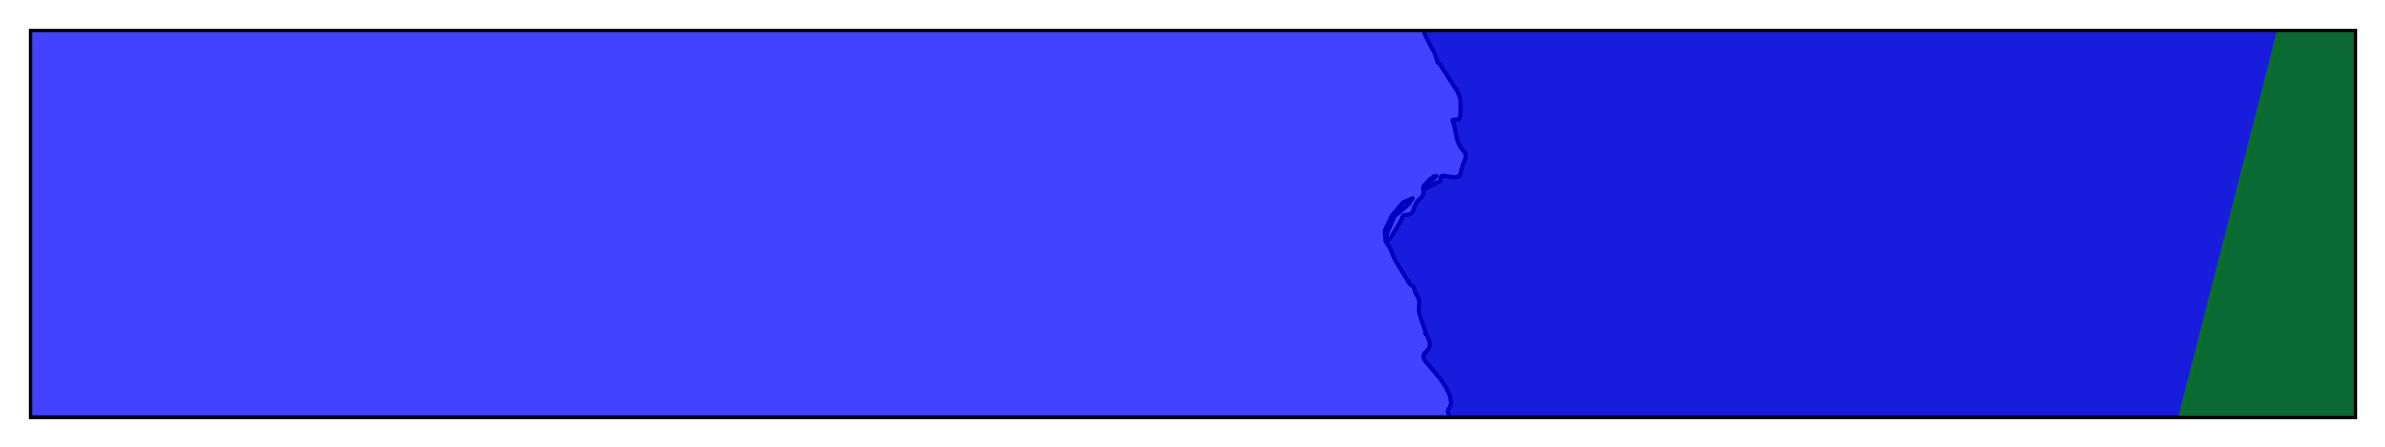

In [14]:
fig1 = plt.figure(figsize=(10, 10), dpi=300)
m = plt.subplot(1, 1, 1, projection=cartopy.crs.PlateCarree())

for polygon, colour in zip([XML_polygon, ROI_polygon, intersection_polygon], ["y", "b", "g"]):
    px = polygon.exterior
    x, y = px.xy
    p, = plt.fill(x, y, alpha=0.74, fc=colour, ec=colour, transform=cartopy.crs.Geodetic(), zorder=1)

m.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='k', facecolor='#5D6D7E')
m.set_extent([min([i[0] for i in roi]), max([i[0] for i in roi]), min([i[1] for i in roi]), max([i[1] for i in roi])])

In [19]:
print (f'Intersection (green): {int(coverage_percentage)}% of ROI polygon (blue)')

Intersection (green): 5% of ROI polygon (blue)


You can use the above number to set a threshold at which you wish to trigger your download.

<hr>
<a href="../Index.ipynb"><< Index</a>
<br>
<a href="./2_2_SLSTR_advanced_cloud_flagging.ipynb">SLSTR advanced cloud flagging >></a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean" target="_blank">View on GitLab</a> | <a href="https://training.eumetsat.int/" target="_blank">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int target="_blank">Contact helpdesk for support </a> | <a href=mailto:training@eumetsat.int target="_blank">Contact our training team to collaborate on and reuse this material</a></span></p>